## **Required Libraries**

In [21]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

from IPython import display

## **loading MNIST dataset**
 It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9

In [22]:
''' loading mnist dataset '''
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [23]:
''' checking shape '''
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


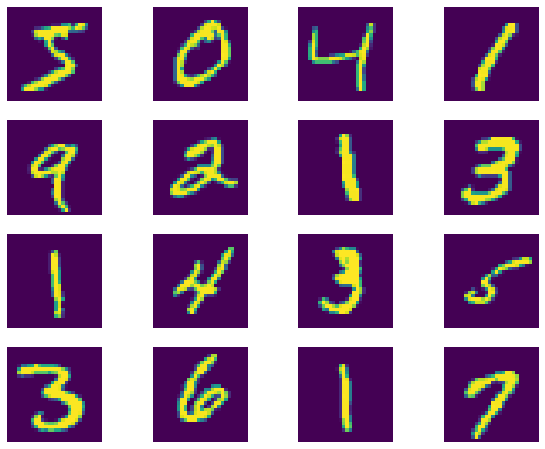

In [24]:
''' plotting some  images '''
plt.figure(figsize=(10, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

## **Reshaping and Normalizing the images**

In [25]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5

In [26]:
''' checking shape of X_trian and X_test '''
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28)


In [27]:
''' loading data in batches '''
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(100).batch(128)

# **GAN's**
- GAN's have two models one is generator, generator learns to create images that look real, while a discriminator learns to tell real images apart from fakes

## **Generator Model**
- Conv2DTranspose Layer 
- Batch Normalization
- LeakyReLU


In [28]:
''' building generator model '''
def generator_model():
  model = tf.keras.Sequential()

  ''' dense layer '''
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  ''' reshaping the output image ''' 
  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  

  ''' conv2DTransposer layer 1 '''
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  ''' conv2DTransposer layer 2 '''
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  ''' conv2DTransposer layer 3 '''
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

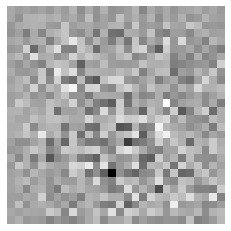

In [29]:
generator = generator_model()

''' creating random data '''
noise = tf.random.normal([1, 100])
output_img = generator(noise, training=False)

''' plotting the output image '''
plt.imshow(output_img[0, :, :, 0], cmap='gray')
plt.axis('off');

## **Discriminator Model**
- Conv2D Layer for feature extraction
- Dropout Layer 
- Flatten Layer
- Dense Layer

In [30]:
''' building discriminator model '''
def discriminator_model():
    model = tf.keras.Sequential()

    ''' conv layer 1 '''
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    ''' Dropout layer '''
    model.add(layers.Dropout(0.3))

    ''' conv layer 2 '''
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    ''' Droput layer ''' 
    model.add(layers.Dropout(0.3))

    ''' Flattening the output image '''
    model.add(layers.Flatten())
    ''' classification laeyr '''
    model.add(layers.Dense(1))

    return model

In [31]:
discriminator = discriminator_model()
result = discriminator(output_img)

In [32]:
print(result)

tf.Tensor([[0.00178504]], shape=(1, 1), dtype=float32)


## **Cross Entropy**
Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events

In [33]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
''' descriminator loss and generator loss '''
def dis_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def ge_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## **Optimizer**

In [35]:
''' discriminator optimizer and generator optimizer ''' 
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

In [36]:
''' setting up some parameters '''
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

''' creating radom seed '''
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [37]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.962765  , -0.61838347, -0.44604307, ...,  0.20193213,
         0.9592353 , -1.2476274 ],
       [ 1.1005477 , -0.9285707 ,  0.14011423, ...,  0.79503095,
         0.43012297, -1.2184714 ],
       [-1.186383  ,  1.5729005 , -1.0412682 , ...,  1.0747546 ,
         1.925013  ,  0.6637318 ],
       ...,
       [ 0.05919628,  0.02519869,  0.80696255, ..., -1.5175749 ,
        -0.36573014, -0.2196196 ],
       [ 0.7130199 ,  0.98796725, -0.30207217, ...,  1.2719723 ,
         2.0127404 ,  1.593073  ],
       [ 0.6560649 ,  0.2653875 ,  0.25765148, ...,  0.7158281 ,
        -0.62604696,  1.4174078 ]], dtype=float32)>

## **Training**

In [38]:
''' training '''

@tf.function
def train_step(images):
    noise = tf.random.normal([128, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = ge_loss(fake_output)
      disc_loss = dis_loss(real_output, fake_output)

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(dis_grad, discriminator.trainable_variables))
  
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

In [39]:
''' generating images and plotting images ''' 
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

In [40]:
train(X_train, EPOCHS)